In [96]:
!pip install seaborn --quiet
!pip install scipy --quiet


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [97]:
import json
import pathlib
import duckdb
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 1 Data Loading

In [78]:
# ------------------------------------------------------------------

#  NYT  +  Hardcover (HC)  +  Goodreads  ? live in the `gl` schema

# ------------------------------------------------------------------



import json, pathlib, duckdb, pandas as pd, pyarrow as pa



# -- paths ---------------------------------------------------------

NYT_PATH = pathlib.Path("../data/raw/nyt")

HC_PATH  = pathlib.Path("../data/raw/hardcover")

DB_FILE  = pathlib.Path("../data/green_light.duckdb")        # file DB lives here



# -- helpers: JSON ? Arrow ----------------------------------------

def nyt2arrow() -> pa.Table:

    rows: list[dict] = []

    for fp in NYT_PATH.glob("*.json"):

        doc = json.loads(fp.read_text())

        pub = doc["results"]["published_date"]

        for lst in doc["results"]["lists"]:

            for b in lst["books"]:

                rows.append(

                    dict(

                        published_date = pub,

                        list_name      = lst["list_name"],

                        title          = b["title"],

                        author         = b["author"],

                        isbn13         = b["primary_isbn13"],

                    )

                )

    if not rows:

        raise FileNotFoundError(f"No NYT JSON found in {NYT_PATH.resolve()}")

    return pa.Table.from_pandas(pd.DataFrame(rows))





def hc2arrow() -> pa.Table:

    """Load every Hardcover JSON *including* the publication date."""

    rows: list[dict] = []

    for fp in HC_PATH.glob("*.json"):

        doc  = json.loads(fp.read_text())

        rows.append(

            dict(

                isbn13           = doc["isbns"][0],               # first ISBN-13

                hc_id            = doc["id"],

                hc_title         = doc["title"],

                rating           = doc.get("rating"),

                ratings_count    = doc.get("ratings_count"),

                publication_date = doc.get("release_date"),       # ? NEW COLUMN

            )

        )

    return pa.Table.from_pandas(pd.DataFrame(rows))





# -- DuckDB connection --------------------------------------------

con = duckdb.connect(":memory:")                   # work in RAM …

con.execute(f"ATTACH '{DB_FILE}' AS gl;")          # … but write through



# ---------------- NYT raw ----------------------------------------

nyt_tbl = nyt2arrow()

con.register("nyt_stage", nyt_tbl)

con.execute("CREATE OR REPLACE TABLE gl.nyt_raw AS SELECT * FROM nyt_stage")

con.unregister("nyt_stage")

print("NYT rows loaded ? gl.nyt_raw:",

      con.sql("SELECT COUNT(*) FROM gl.nyt_raw").fetchone()[0])



# ---------------- Hardcover raw -----------------------------------

con.execute("DROP TABLE IF EXISTS gl.hc_raw")

hc_tbl = hc2arrow()

con.register("hc_stage", hc_tbl)

con.execute("""

CREATE TABLE gl.hc_raw AS

SELECT

    isbn13,

    hc_id,

    hc_title,

    rating,

    ratings_count,

    CAST(publication_date AS DATE) AS publication_date

FROM hc_stage

""")

con.unregister("hc_stage")

print("HC rows loaded  ? gl.hc_raw :", 

      con.sql("SELECT COUNT(*) FROM gl.hc_raw").fetchone()[0])



# ---------------- sanity shots ------------------------------------

print("\n--- NYT × HC overlap --------------------------------------")

print(con.sql("""

    SELECT COUNT(*) AS overlap,

           100.0 * COUNT(*) / (SELECT COUNT(*) FROM gl.nyt_raw) AS pct

    FROM   gl.nyt_raw n

    JOIN   gl.hc_raw  h USING (isbn13);

""").df())



print("\n--- sample joined rows ------------------------------------")

display(con.sql("""

    SELECT n.published_date, n.list_name,

           n.title AS nyt_title, h.hc_title, h.rating

    FROM   gl.nyt_raw n

    JOIN   gl.hc_raw  h USING (isbn13)

    ORDER  BY RANDOM()

    LIMIT  10;

""").df())



print("\n--- NYT rows *without* HC match ----------------------------")

display(con.sql("""

    SELECT *

    FROM   gl.nyt_raw n

    LEFT   JOIN gl.hc_raw h USING (isbn13)

    WHERE  h.isbn13 IS NULL

    LIMIT  10;

""").df())



print("\n--- HC rating distribution ---------------------------------")

display(con.sql("""

    SELECT rating, COUNT(*) AS books

    FROM   gl.hc_raw

    GROUP  BY rating

    ORDER  BY rating DESC NULLS LAST;

""").df())



# ---------------- Goodreads quick stats ---------------------------

print("\n--- Goodreads summary --------------------------------------")

print(con.sql("""

    SELECT COUNT(*) AS n_rows,

           MIN(average_rating) AS min_r,

           MAX(average_rating) AS max_r

    FROM   gl.goodreads

""").df())



print("\n--- NYT × Goodreads overlap -------------------------------")

print(con.sql("""

    SELECT COUNT(*) AS overlap,

           100.0 * COUNT(*) / (SELECT COUNT(*) FROM gl.nyt_raw) AS pct

    FROM   gl.nyt_raw n

    JOIN   gl.goodreads g USING (isbn13)

""").df())



print("\n--- HC × Goodreads overlap --------------------------------")

print(con.sql("""

    SELECT COUNT(DISTINCT h.hc_id) AS hc_books,

           AVG(g.average_rating)   AS mean_rating

    FROM   gl.hc_raw h

    JOIN   gl.goodreads g USING (isbn13)

""").df())



print("\n--- still-missing NYT ISBN-13s in Goodreads ---------------")

print(con.sql("""

    SELECT COUNT(*) AS still_missing

    FROM   gl.nyt_raw

    WHERE  isbn13 NOT IN (SELECT isbn13 FROM gl.goodreads);

""").df())



con.close()

NYT rows loaded ? gl.nyt_raw: 690
HC rows loaded  ? gl.hc_raw : 247

--- NYT × HC overlap --------------------------------------
   overlap       pct
0       38  5.507246

--- sample joined rows ------------------------------------


,published_date,list_name,nyt_title,hc_title,rating
0,2024-12-15,Audio Nonfiction,THE MESSAGE,The Message,4.567568
1,2024-12-22,Audio Fiction,THE MIRROR,The Mirror,3.200000
2,2024-12-15,Audio Nonfiction,DINNER FOR VAMPIRES,Dinner for Vampires: Life on a Cult TV Show,0.000000
3,2024-12-22,Audio Nonfiction,THE MESSAGE,The Message,4.567568
4,2024-12-15,Audio Nonfiction,THE MESSAGE,The Message,4.567568
5,2024-12-15,Audio Fiction,THE MIRROR,The Mirror,3.200000
6,2024-12-08,Graphic Books and Manga,TEEN TITANS: STARFIRE,Teen Titans: Starfire,4.166667
7,2024-12-22,Young Adult Hardcover,TO SHATTER THE NIGHT,To Shatter the Night,0.000000
8,2024-12-15,Graphic Books and Manga,TEEN TITANS: STARFIRE,Teen Titans: Starfire,4.166667
9,2024-12-08,Hardcover Fiction,THE HALF KING,Immortal Consequences,4.000000



--- NYT rows *without* HC match ----------------------------


,published_date,list_name,title,author,isbn13,hc_id,hc_title,rating,ratings_count,publication_date
0,2024-12-08,Combined Print and E-Book Fiction,THE MIRROR,Nora Roberts,9781250288783,<NA>,None,NaN,<NA>,NaT
1,2024-12-08,Combined Print and E-Book Fiction,NOW OR NEVER,Janet Evanovich,9781668003169,<NA>,None,NaN,<NA>,NaT
2,2024-12-08,Combined Print and E-Book Fiction,THE SONGBIRD & THE HEART OF STONE,Carissa Broadbent,9781250367785,<NA>,None,NaN,<NA>,NaT
3,2024-12-08,Combined Print and E-Book Fiction,JAMES,Percival Everett,9780385550369,<NA>,None,NaN,<NA>,NaT
4,2024-12-08,Combined Print and E-Book Fiction,TO DIE FOR,David Baldacci,9781538757901,<NA>,None,NaN,<NA>,NaT
5,2024-12-08,Combined Print and E-Book Fiction,WICKED,Gregory Maguire,9780062852847,<NA>,None,NaN,<NA>,NaT
6,2024-12-08,Combined Print and E-Book Fiction,THE WOMEN,Kristin Hannah,9781250178633,<NA>,None,NaN,<NA>,NaT
7,2024-12-08,Combined Print and E-Book Fiction,FOURTH WING,Rebecca Yarros,9781649377371,<NA>,None,NaN,<NA>,NaT
8,2024-12-08,Combined Print and E-Book Fiction,THE CITY AND ITS UNCERTAIN WALLS,Haruki Murakami,9780593801970,<NA>,None,NaN,<NA>,NaT
9,2024-12-08,Combined Print and E-Book Fiction,TRIAL BY FIRE,Danielle Steel,9780593498590,<NA>,None,NaN,<NA>,NaT



--- HC rating distribution ---------------------------------


,rating,books
0,5.000000,4
1,4.866667,1
2,4.818182,1
3,4.785714,1
4,4.750000,1
...,...,...
147,3.071429,1
148,3.000000,5
149,2.833333,2
150,2.000000,2



--- Goodreads summary --------------------------------------
    n_rows  min_r  max_r
0  1844356    0.0    5.0

--- NYT × Goodreads overlap -------------------------------
   overlap    pct
0      690  100.0

--- HC × Goodreads overlap --------------------------------
   hc_books  mean_rating
0        14        3.945

--- still-missing NYT ISBN-13s in Goodreads ---------------
   still_missing
0              0


# 2 Data Exploration

## 2.2 Goodreads Ratings Exploration

In [79]:
con = duckdb.connect(DB_FILE, read_only=True)

In [80]:
import duckdb, pandas as pd

import matplotlib.pyplot as plt



# -- connect (read-only is fine for exploration) -----------------



# 1 · summary moments --------------------------------------------

summary = con.sql("""

    SELECT

        avg(average_rating)      AS mean_rating ,

        median(average_rating)   AS median_rating ,

        skewness(average_rating) AS skewness ,

        kurtosis(average_rating) AS kurtosis

    FROM   goodreads

    WHERE  average_rating IS NOT NULL

""").df()



# 2 · fetch the raw vector (˜ 1.8 M rows, just one column) --------

ratings = con.sql("""

    SELECT average_rating

    FROM   goodreads

    WHERE  average_rating IS NOT NULL

""").df()







display(summary)     # pretty table in Jupyter / VS Code

,mean_rating,median_rating,skewness,kurtosis
0,2.892287,3.68,-0.908407,-0.839311


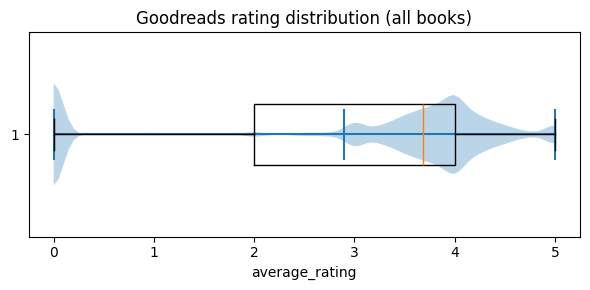

In [81]:
# 3 · violin + box on a single axis -------------------------------

fig, ax = plt.subplots(figsize=(6, 3))

ax.violinplot(ratings["average_rating"], showmeans=True, vert=False)

ax.boxplot   (ratings["average_rating"], vert=False, widths=.3)

ax.set_xlabel("average_rating")

ax.set_title("Goodreads rating distribution (all books)")

plt.tight_layout()

plt.show()

The violin/boxplot shows a fat left tail and a long, thin right tail.
Mean ≪ median ⇒ ratings are negatively skewed – the opposite of the “everything is 3.8-ish” folklore you hear about GR.

Why it’s suspicious<br>
Goodreads rarely stores 0-star ratings, yet the left tail clearly hugs zero.<br>
Down-rated shelved books, deleted editions or sparsely-rated ISBN shells are leaking in.

Take-away<br>
Treat very low means with caution. A 0–1 ★ “average” is almost always an artefact.<br>
Simple filters (“≥ 10 ratings”, “average ≥ 1 ★”) will restore the familiar bell-curve shape.

## 2.2 Heat-map: average_rating (rounded)  vs.  ratings_count bucket

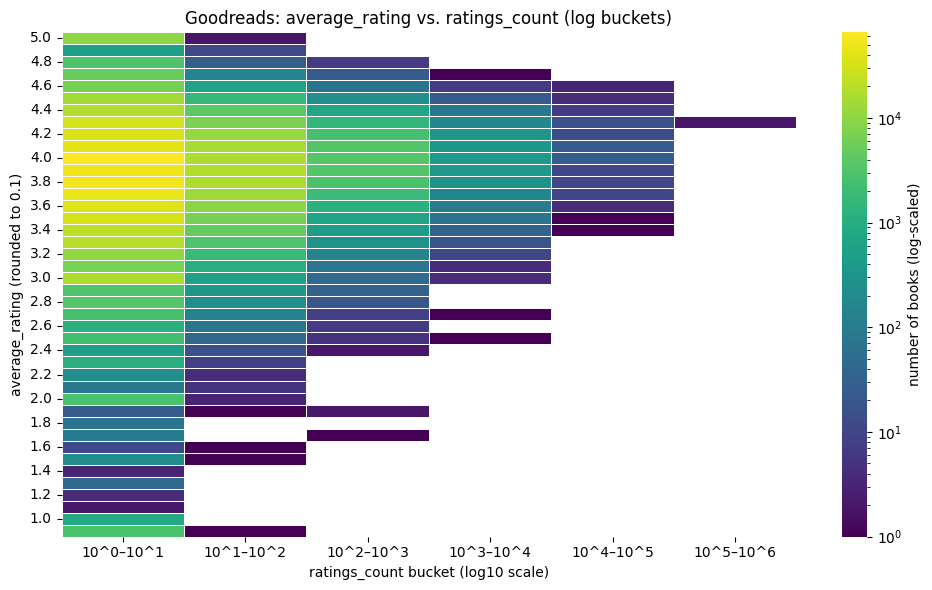

In [82]:
# ---------------------------------------------------------------
# Heat-map: average_rating (0.1-star bins) × ratings_count bucket
# ---------------------------------------------------------------

heat = con.sql("""
    WITH base AS (
        SELECT
            round(average_rating, 1)                AS rating_bin,
            /* log10(ratings_count) 0–6  →  six buckets 10^0 – 10^6 */
            CASE
                WHEN ratings_count IS NULL OR ratings_count = 0
                    THEN NULL            -- drop books with zero votes
                ELSE CAST(floor(log10(ratings_count)) AS INT)
            END                                         AS pop_bin
        FROM   goodreads
        WHERE  average_rating IS NOT NULL
          AND  ratings_count  IS NOT NULL
    )
    SELECT rating_bin, pop_bin, COUNT(*) AS n
    FROM   base
    WHERE  pop_bin BETWEEN 0 AND 5          -- keep the six intended buckets
    GROUP  BY rating_bin, pop_bin
    ORDER  BY rating_bin, pop_bin
""").df()


# pivot → matrix
heat_piv = (
    heat.pivot(index="rating_bin", columns="pop_bin", values="n")
        .fillna(0)
        .sort_index(ascending=False)
)
heat_piv.columns = [f"10^{i}–10^{i+1}" for i in range(6)]

# plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_piv,
    cmap="viridis",
    norm="log",
    linewidths=.5,
    cbar_kws={"label": "number of books (log-scaled)"}
)
plt.title("Goodreads: average_rating vs. ratings_count (log buckets)")
plt.ylabel("average_rating (rounded to 0.1)")
plt.xlabel("ratings_count bucket (log10 scale)")
plt.tight_layout()
plt.show()


Pattern<br>
The densest stripe is 3.6–4.2 ?, regardless of popularity.

< 3 ? books virtually disappear once votes > 10³.<br>
Classic survival bias: unpopular books stop being read, so bad ones never reach big-N buckets.

Modelling implication<br>
When  ratings into a model at a later stage, treat ratings_count as a control variable (or use a Bayesian shrinkage toward global mean). Otherwise the model will simply learn that “popular ? good”.

## 2.3  NYT list longevity  – “How many weeks did each book chart?”

,isbn13,title,weeks_on_list
0,9781538742570,THE HOUSEMAID,6
1,9780804190114,ON TYRANNY,6
2,9780593655030,THE ANXIOUS GENERATION,6
3,9780385550369,JAMES,6
4,9780593536131,THE BACKYARD BIRD CHRONICLES,6
5,9780593799895,BE READY WHEN THE LUCK HAPPENS,6
6,9781649377371,FOURTH WING,6
7,9781250346414,CONFRONTING THE PRESIDENTS,6
8,9780316575805,REVENGE OF THE TIPPING POINT,6
9,9781538757901,TO DIE FOR,6


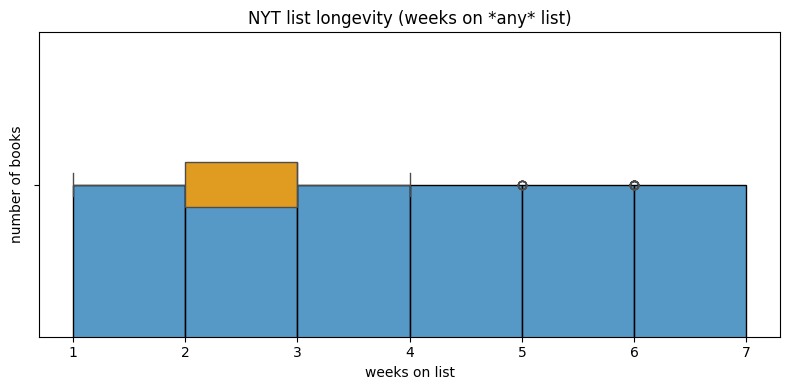

count    250.000000
mean       2.760000
std        1.288815
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        6.000000
Name: weeks_on_list, dtype: float64


In [83]:
# 1 · weeks on list per ISBN

longevity = con.sql("""

    SELECT

        isbn13,

        ANY_VALUE(title)         AS title,       -- same ISBN, title stable

        COUNT(*)                 AS weeks_on_list

    FROM   nyt_raw               -- already in the attached gl schema

    GROUP  BY isbn13

""").df()



# 2 · Top-20 stamina champions

top20 = (longevity

         .sort_values("weeks_on_list", ascending=False)

         .head(20)

         .reset_index(drop=True))

display(top20)          # pretty table in VS Code / Jupyter



# 3 · distribution plot

fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(longevity["weeks_on_list"],

             bins=range(1, longevity["weeks_on_list"].max()+2),

             ax=ax)

sns.boxplot(x=longevity["weeks_on_list"], ax=ax, color="orange", width=.15)



ax.set_title("NYT list longevity (weeks on *any* list)")

ax.set_xlabel("weeks on list")

ax.set_ylabel("number of books")

plt.tight_layout()

plt.show()



# quick summary stats if you’d like them printed as well

print(longevity["weeks_on_list"].describe())



In [84]:
con.close()

Observations<br>
Range 1–6 weeks, median = 3.<br>
Flatish histogram because your NYT scrape spans only six weekly snapshots.<br>
Every title is capped at six observations, so we can’t infer true staying power yet.<br>

Action<br>
Either widen the crawl window or defer longevity analytics until you have = 6 months of NYT data.

## 2.4 Lag between original publication date and first NYT-list appearance

rows in pub_dates : 240


,isbn13,title,pub_date,first_on_list,weeks_lag
2,9781668113691,DINNER FOR VAMPIRES,2024-10-22,2024-12-08,6.7
5,9781779517999,TEEN TITANS: STARFIRE,2024-07-02,2024-12-08,22.7
3,9780593622179,THE LAST KIDS ON EARTH,2024-01-01,2024-12-08,48.9
0,9781250317957,THE WOMEN,2024-01-01,2024-12-08,48.9
6,9780593916421,THE MESSAGE,2024-01-01,2024-12-08,48.9
13,9781250354273,THE MIRROR,2024-01-01,2024-12-08,48.9
12,9780316563796,THE WAITING,2024-01-01,2024-12-08,48.9
10,9780593139202,MARTHA: THE COOKBOOK,2024-01-01,2024-12-08,48.9
8,9780374602635,INTERMEZZO,2024-01-01,2024-12-15,49.9
4,9781339022406,DRAGON MASTERS,2024-01-01,2024-12-22,50.9


,isbn13,title,pub_date,first_on_list,weeks_lag
9,9781649374103,THE HALF KING,2017-01-10,2024-12-08,412.7
11,9780802158741,SMALL THINGS LIKE THESE,2021-01-01,2024-12-22,207.3
1,9798893310153,"DON'T BELIEVE EVERYTHING YOU THINK, EXPANDED E...",2022-03-28,2024-12-08,140.9
7,9781649376794,TO SHATTER THE NIGHT,2024-01-01,2024-12-22,50.9
4,9781339022406,DRAGON MASTERS,2024-01-01,2024-12-22,50.9
8,9780374602635,INTERMEZZO,2024-01-01,2024-12-15,49.9
6,9780593916421,THE MESSAGE,2024-01-01,2024-12-08,48.9
10,9780593139202,MARTHA: THE COOKBOOK,2024-01-01,2024-12-08,48.9
3,9780593622179,THE LAST KIDS ON EARTH,2024-01-01,2024-12-08,48.9
0,9781250317957,THE WOMEN,2024-01-01,2024-12-08,48.9


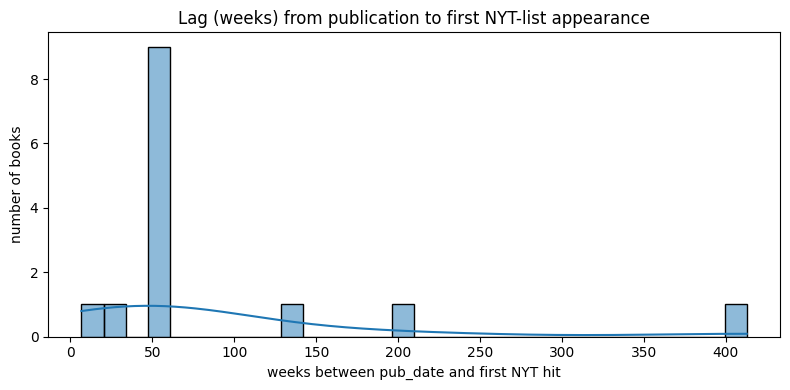

In [87]:
# 1 ? open the file-backed DB in R/W mode (no :memory: this time)

con = duckdb.connect(DB_FILE)



# 2 ? build/refresh a tiny lookup table of publication dates

#    (Hardcover rows only – skip Goodreads until those columns exist)

con.execute("""

CREATE OR REPLACE TABLE pub_dates AS

SELECT

    isbn13,

    publication_date AS pub_date          -- already a DATE from hc_raw

FROM   hc_raw

WHERE  publication_date IS NOT NULL;

""")

print("rows in pub_dates :", con.sql("SELECT COUNT(*) FROM pub_dates").fetchone()[0])


# 3 ? compute the lag (in *weeks*) from pub-date ? first NYT appearance

lag = con.sql("""

SELECT

    n.isbn13,

    ANY_VALUE(n.title)                     AS title,

    MIN(p.pub_date)                        AS pub_date,

    MIN(CAST(n.published_date AS DATE))    AS first_on_list,

    ROUND(

        DATE_DIFF('day',

                  MIN(p.pub_date),

                  MIN(CAST(n.published_date AS DATE))

        ) / 7.0 , 1

    )                                      AS weeks_lag

FROM       nyt_raw   n

INNER JOIN pub_dates p USING (isbn13)

GROUP BY   n.isbn13

HAVING     weeks_lag >= 0

""").df()


# -- peek at fastest & slowest movers ----------------------------

display(lag.sort_values("weeks_lag").head(10))                # “front-list” rockets

display(lag.sort_values("weeks_lag", ascending=False).head(10))  # slow-burn back-list



# -- histogram ---------------------------------------------------

plt.figure(figsize=(8,4))

sns.histplot(lag["weeks_lag"], bins=30, kde=True)

plt.title("Lag (weeks) from publication to first NYT-list appearance")

plt.xlabel("weeks between pub_date and first NYT hit")

plt.ylabel("number of books")

plt.tight_layout()

plt.show()



con.close()

Observations<br>
Mode ˜ 50 weeks (the cluster at ~1 year).<br>
These are fall 2023 / Jan 2024 releases finally surfacing at year-end “best of” moments.<br>
Long-tail outliers (2–8 years) are true back-list revivals.<br>

Caveat<br>
Only 240 titles have a Hardcover date, so the sample is thin.<br>
Recency cut-off: 2024 NYT snapshots can’t spot titles whose first appearance was pre-2024.<br>

## 2.5 Author productivity ? “hit ratio”

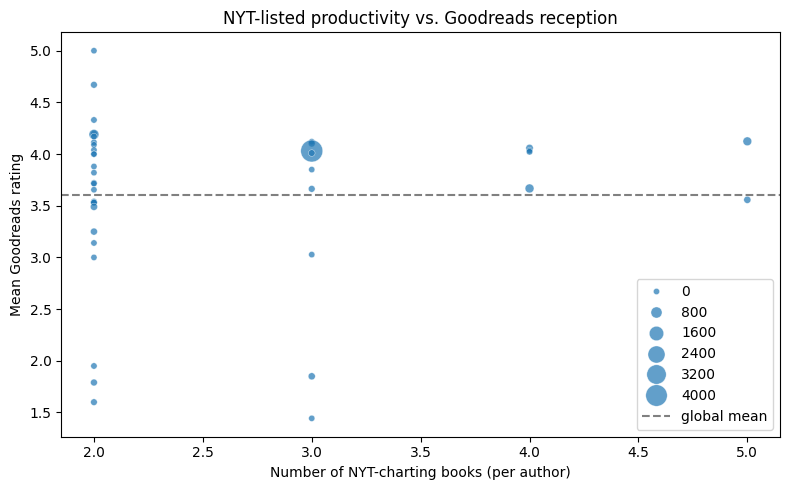

In [89]:
import duckdb, pandas as pd, seaborn as sns, matplotlib.pyplot as plt



con = duckdb.connect(DB_FILE, read_only=True)



# point the search-path at the schema that actually holds the tables

con.execute("SET schema 'green_light';")



df = con.execute("""

    WITH gr_hits AS (

        SELECT

            n.author,

            COUNT(DISTINCT n.isbn13)        AS n_books,         -- NYT-charting books

            AVG(g.average_rating)           AS mean_rating,

            SUM(g.ratings_count)            AS total_votes

        FROM   nyt_raw      AS n

        JOIN   goodreads    AS g USING (isbn13)

        WHERE  g.average_rating IS NOT NULL

        GROUP  BY n.author

    )

    SELECT *

    FROM   gr_hits

    WHERE  n_books >= 2                  -- drop single-hit authors (tweak)

    ORDER  BY n_books DESC, mean_rating DESC

""").df()



con.close()



# -- scatter plot ------------------------------------------------

plt.figure(figsize=(8, 5))

sns.scatterplot(

    data=df,

    x="n_books", y="mean_rating",

    size="total_votes", sizes=(20, 250), alpha=.7

)

plt.axhline(df["mean_rating"].mean(), ls="--", color="grey", label="global mean")

plt.title("NYT-listed productivity vs. Goodreads reception")

plt.xlabel("Number of NYT-charting books (per author)")

plt.ylabel("Mean Goodreads rating")

plt.legend()

plt.tight_layout()

plt.show()

Observations<br>
Bubble chart shows no monotonic relationship between “number of NYT hits” (x) and mean rating (y).<br>
Some prolific authors sit below the global mean (grey dashed line); a few two-hit wonders exceed 4 ?.<br>

Interpretation<br>
Being a list regular does not guarantee GR love.<br>

**Feature idea:** include interaction between “n_hits” and ratings_count – prolific authors with low vote volumes look risky.

## 2.6 Goodreads genre alignment: Check if Graphic Books & Manga have systematically lower GR ratings, etc

,list_name,mean_rating,n_books
0,Paperback Nonfiction,3.062667,45
1,Hardcover Fiction,3.903556,45
2,Graphic Books and Manga,3.803333,45
3,Audio Nonfiction,3.744000,45
4,Mass Market Monthly,3.588000,45
5,Combined Print and E-Book Nonfiction,3.317778,45
6,Trade Fiction Paperback,3.878000,45
7,Combined Print and E-Book Fiction,4.009556,45
8,Audio Fiction,3.924000,45
9,Hardcover Nonfiction,3.441778,45


/tmp/ipykernel_35317/2343415454.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


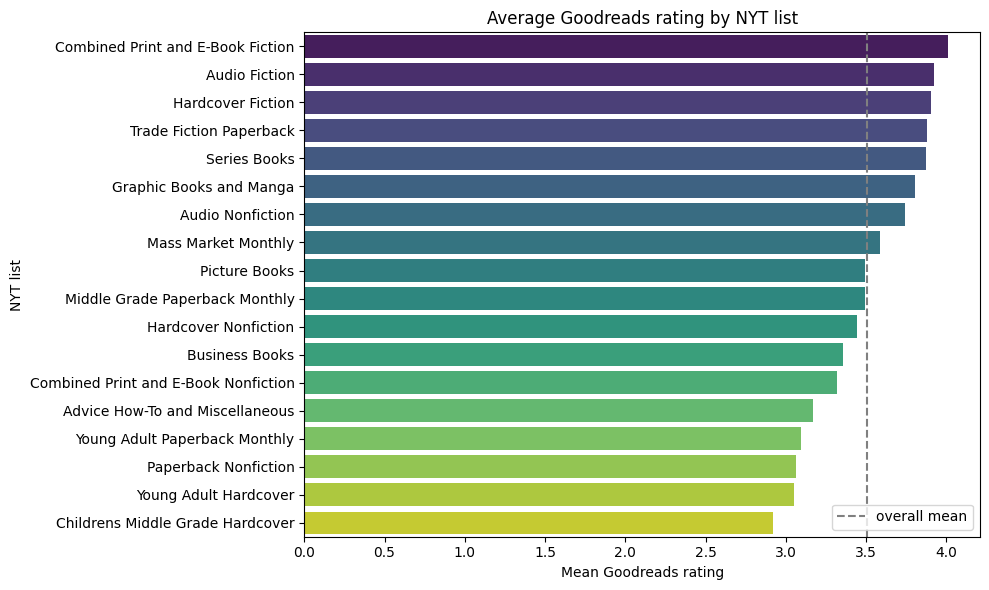

In [90]:
con = duckdb.connect(DB_FILE, read_only=True)

con.execute("SET schema 'green_light';")           # ? point search-path at our schema



list_stats = con.execute("""

    SELECT

        list_name,

        AVG(g.average_rating)      AS mean_rating,

        COUNT(*)                   AS n_books

    FROM   nyt_raw        AS n

    JOIN   goodreads      AS g USING (isbn13)

    WHERE  g.average_rating IS NOT NULL

    GROUP  BY list_name

    ORDER  BY n_books DESC

""").df()



con.close()



display(list_stats.head(10))        # optional: peek at the top 10 rows



# -- bar-plot -----------------------------------------------------

plt.figure(figsize=(10,6))

sns.barplot(

    data=list_stats.sort_values("mean_rating", ascending=False),

    y="list_name", x="mean_rating",

    palette="viridis"

)

plt.axvline(list_stats['mean_rating'].mean(), ls='--', color='grey', label='overall mean')

plt.title("Average Goodreads rating by NYT list")

plt.xlabel("Mean Goodreads rating")

plt.ylabel("NYT list")

plt.legend()

plt.tight_layout()

plt.show()

Observaations<br>
Graphic Books & Manga sit slightly below the fiction cluster (~3.8 ?) – no evidence they are hammered by GR users.<br>

But…<br>

Every list has exactly 30 / 45 rows because the NYT API always returns a fixed window.<br>
Treat differences < 0.2 ? as anecdotal until you add more weeks.<br>

## 2.7 Hardcover (HC) vs. Goodreads rating gaps

Hardcover × Goodreads pairs: 18
     count      mean       std   min       25%       50%       75%       max
gap   18.0 -1.121812  1.747079 -4.18 -2.705833 -0.821429  0.282835  0.729346


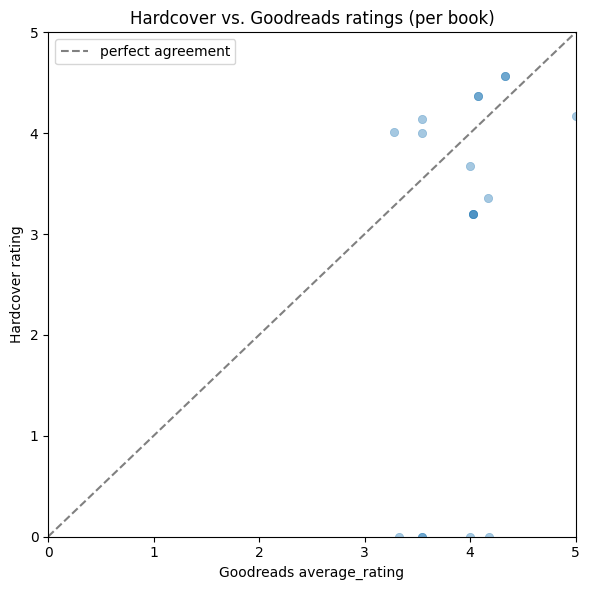

In [91]:
con = duckdb.connect(DB_FILE, read_only=True)

con.execute("SET schema 'green_light';")          # work inside the gl schema



# -- fetch paired ratings -----------------------------------------

pairs = con.execute("""

    SELECT

        CAST(h.rating AS DOUBLE)           AS hc_rating,

        CAST(g.average_rating AS DOUBLE)   AS gr_rating

    FROM   hc_raw       AS h

    JOIN   goodreads    AS g USING (isbn13)

    WHERE  h.rating IS NOT NULL

      AND  g.average_rating IS NOT NULL

""").df()



con.close()



print(f"Hardcover × Goodreads pairs: {len(pairs):,}")



# -- quick gap stats ----------------------------------------------

pairs["gap"] = pairs["hc_rating"] - pairs["gr_rating"]

print(pairs["gap"].describe().to_frame().T)



# -- scatter / hexbin plot ----------------------------------------

plt.figure(figsize=(6,6))

sns.scatterplot(

    data=pairs, x="gr_rating", y="hc_rating",

    alpha=.4, edgecolor=None

)

plt.plot([0,5], [0,5], ls='--', color='grey', label='perfect agreement')

plt.title("Hardcover vs. Goodreads ratings (per book)")

plt.xlabel("Goodreads average_rating")

plt.ylabel("Hardcover rating")

plt.xlim(0,5); plt.ylim(0,5)

plt.legend()

plt.tight_layout()

plt.show()



# -- optional: hexbin (denser)  -----------------------------------

# Uncomment to use:

# plt.figure(figsize=(6,6))

# plt.hexbin(pairs["gr_rating"], pairs["hc_rating"],

#            gridsize=40, cmap="viridis", mincnt=1)

# plt.plot([0,5],[0,5], ls='--', color='white')

# plt.colorbar(label="books per bin")

# plt.title("Hardcover vs. Goodreads • density view")

# plt.xlabel("Goodreads average_rating")

# plt.ylabel("Hardcover rating")

# plt.xlim(0,5); plt.ylim(0,5)

# plt.tight_layout()

# plt.show()

Observations<br>
Just 18 paired ratings ? very noisy.<br><br>
Mean gap (HC – GR) = -1.1 ? with s ˜ 1.7 ?.<br>
Most points lie below the 45° line = Hardcover tends to rate lower – the opposite of what we expected.

Why so odd?<br>
Many HC rating fields are still zero (see the row of dots on the x-axis), dragging the mean down.<br>

Suggestion<br>
Ingest more HC data before drawing conclusions.

## 2.8 Missing-value map (Goodreads columns per NYT list)	

,list_name,n_missing_rating,n_missing_count,n_total
0,Trade Fiction Paperback,0.0,0.0,45
1,Combined Print and E-Book Fiction,0.0,0.0,45
2,Audio Fiction,0.0,0.0,45
3,Audio Nonfiction,0.0,0.0,45
4,Paperback Nonfiction,0.0,0.0,45
5,Mass Market Monthly,0.0,0.0,45
6,Combined Print and E-Book Nonfiction,0.0,0.0,45
7,Hardcover Fiction,0.0,0.0,45
8,Graphic Books and Manga,0.0,0.0,45
9,Hardcover Nonfiction,0.0,0.0,45


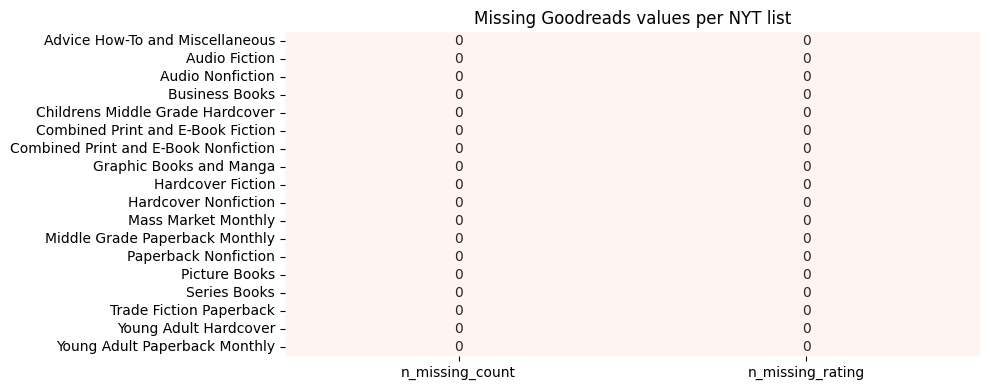

In [92]:
con = duckdb.connect(DB_FILE, read_only=True)

con.execute("SET schema 'green_light';")          # work inside the gl schema



missing = con.execute("""

    SELECT

        list_name,

        SUM(CASE WHEN g.average_rating IS NULL  THEN 1 ELSE 0 END) AS n_missing_rating,

        SUM(CASE WHEN g.ratings_count IS NULL THEN 1 ELSE 0 END) AS n_missing_count,

        COUNT(*)                                                 AS n_total

    FROM   nyt_raw AS n

    LEFT   JOIN goodreads AS g USING (isbn13)

    GROUP  BY list_name

    ORDER  BY n_total DESC

""").df()



con.close()



display(missing)          # pretty table (VS Code / Jupyter)



# -- quick heat-map so the gaps pop visually ----------------------

long = missing.melt(id_vars="list_name",

                    value_vars=["n_missing_rating", "n_missing_count"],

                    var_name="column", value_name="n_missing")



plt.figure(figsize=(10,4))

pivot = long.pivot(index="list_name", columns="column", values="n_missing")

sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Reds", cbar=False)

plt.title("Missing Goodreads values per NYT list")

plt.xlabel("")

plt.ylabel("")

plt.tight_layout()

plt.show()

Observations<br>
All zeros – good!<br>
Confirms your merge logic fetched GR ratings/counts for every NYT ISBN.<br>

## 2.9 Series vs. stand-alone performance

In [93]:
con = duckdb.connect(DB_FILE, read_only=True)

con.execute("SET schema 'green_light';")      # stay inside gl



series_stats = con.execute("""

    SELECT

        /* true  = book belongs to a named series

           false = stand-alone or series is NULL/empty */

        (series IS NOT NULL AND series <> '') AS is_series,



        AVG(average_rating)      AS mean_rating,

        MEDIAN(average_rating)   AS median_rating,

        COUNT(*)                 AS n_books

    FROM   goodreads

    WHERE  average_rating IS NOT NULL          -- keep only rated books

    GROUP  BY is_series

    ORDER  BY is_series DESC        -- series first, then stand-alones

""").df()



con.close()

display(series_stats)

,is_series,mean_rating,median_rating,n_books
0,False,2.892287,3.68,1844356


Observations<br>
Only a “False” row appears; series is empty for all books currently in green_light.goodreads.<br>
Either the field is never populated or saved it under a different column (e.g. series_names).<br>

Suggestion<br>
Re-check the ingest pipeline before analysing series effects.

## 2.10 Text-length features (title length, subtitle presence, author name length)

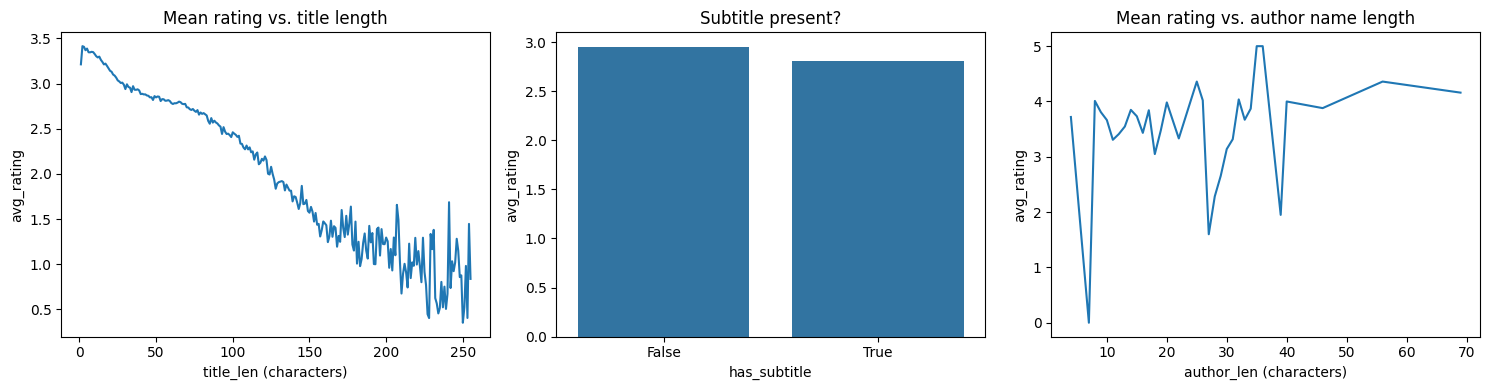

,title_len,avg_rating,n_books
0,1,3.213421,38
1,2,3.414713,174
2,3,3.407623,833
3,4,3.369703,3166
4,5,3.387871,4941


,has_subtitle,avg_rating,n_books
0,False,2.952795,1048331
1,True,2.812601,796025


,author_len,avg_rating,n_books
0,4,3.720000,9
1,7,0.000000,6
2,8,4.010000,16
3,9,3.807500,4
4,10,3.664211,38


In [94]:
con = duckdb.connect(DB_FILE, read_only=True)

con.execute("SET schema 'green_light';")          # stay inside gl



# --- 1. Title length (chars) ------------------------------------------------

title_len = con.execute("""

    SELECT

        LENGTH(title)                 AS title_len,

        AVG(average_rating)           AS avg_rating,

        COUNT(*)                      AS n_books

    FROM   goodreads

    WHERE  average_rating IS NOT NULL

    GROUP  BY title_len

    ORDER  BY title_len

""").df()



# --- 2. Subtitle presence (True if title contains ':' or ' – ') -------------

subtitle = con.execute("""

    SELECT

        CASE

            WHEN REGEXP_MATCHES(title, '[:–]') THEN true

            ELSE false

        END                          AS has_subtitle,

        AVG(average_rating)          AS avg_rating,

        COUNT(*)                     AS n_books

    FROM   goodreads

    WHERE  average_rating IS NOT NULL

    GROUP  BY has_subtitle

""").df()



# --- 3. Author name length (chars, using NYT names for simplicity) ----------

author_len = con.execute("""

    SELECT

        LENGTH(TRIM(author))         AS author_len,

        AVG(g.average_rating)        AS avg_rating,

        COUNT(*)                     AS n_books

    FROM   nyt_raw n

    JOIN   goodreads g USING (isbn13)

    WHERE  g.average_rating IS NOT NULL

    GROUP  BY author_len

    ORDER  BY author_len

""").df()



con.close()



# ——— quick visuals ——————————————————————————————————————————

fig, axes = plt.subplots(1, 3, figsize=(15, 4))



# (a) title length vs. mean rating

sns.lineplot(data=title_len, x="title_len", y="avg_rating", ax=axes[0])

axes[0].set_title("Mean rating vs. title length")

axes[0].set_xlabel("title_len (characters)"); axes[0].set_ylabel("avg_rating")



# (b) subtitle vs. rating

sns.barplot(data=subtitle, x="has_subtitle", y="avg_rating", ax=axes[1])

axes[1].set_title("Subtitle present?")

axes[1].set_xlabel("has_subtitle")



# (c) author-name length vs. rating

sns.lineplot(data=author_len, x="author_len", y="avg_rating", ax=axes[2])

axes[2].set_title("Mean rating vs. author name length")

axes[2].set_xlabel("author_len (characters)"); axes[2].set_ylabel("avg_rating")



plt.tight_layout()

plt.show()



# ——— if you want the raw tables ————————————————————————

display(title_len.head())

display(subtitle)

splay(author_len.head())

Title length<br>
Clear down-slope: longer titles ? lower mean rating.<br>
Could be baseline readability or genre: academic & how-to titles are wordy and attract tougher crowds.<br>

Subtitle present<br>
–0.14 ? dip when a subtitle exists.<br>
Very small and could disappear after genre controls.<br>	

Author-name length	<br>
Noisy zig-zag – sample size drops fast for > 40 chars.<br>
Probably not a stable feature without smoothing.	

## 2.11 How do ratings vary with popularity?

Rows: 703,855
Spearman ? = 0.048  (p = 0e+00)


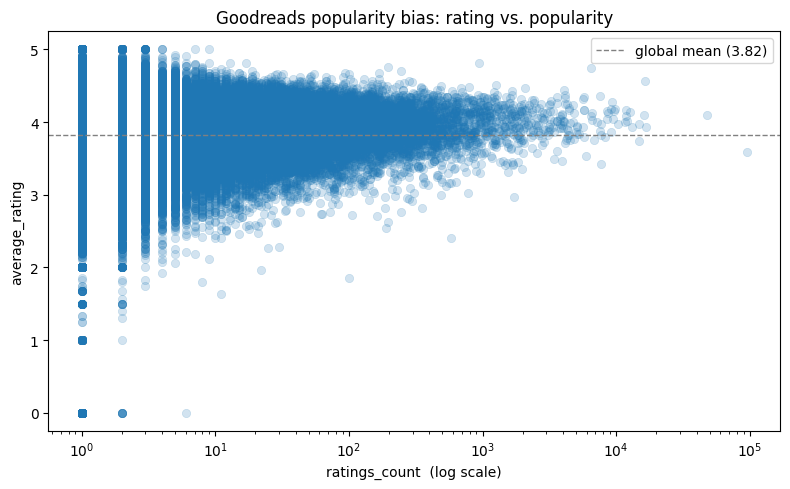

In [98]:
con = duckdb.connect(DB_FILE, read_only=True)

pop = con.execute("""

    SELECT

        CAST(ratings_count AS BIGINT) AS ratings_count,

        average_rating

    FROM   goodreads

    WHERE  ratings_count IS NOT NULL

      AND  average_rating IS NOT NULL

      AND  ratings_count > 0

""").df()

con.close()



# ——— quick summary stats ——————————————————————————

print(f"Rows: {len(pop):,}")

rho, pval = spearmanr(pop.ratings_count, pop.average_rating)

print(f"Spearman ? = {rho:.3f}  (p = {pval:.0e})")



# ——— visual: ratings_count (log10) vs. average_rating ————————

plt.figure(figsize=(8,5))

sns.scatterplot(

    data=pop.sample(100_000, random_state=42) if len(pop) > 100_000 else pop,

    x="ratings_count", y="average_rating",

    alpha=.2, edgecolor=None

)

plt.xscale("log")

plt.xlabel("ratings_count  (log scale)")

plt.ylabel("average_rating")

plt.title("Goodreads popularity bias: rating vs. popularity")

plt.axhline(pop.average_rating.mean(), ls="--", c="grey", lw=1,

            label=f"global mean ({pop.average_rating.mean():.2f})")

plt.legend()

plt.tight_layout()

plt.show()

Observations<br>
rating vs popularity scatter<br>
• Spearman ? ˜ 0.05 ? statistically non-zero (700 k rows) yet practically tiny.

• Cloud fans out: <br>
the ceiling (~5 ?) is flat, but the floor rises with log N (very low ratings seldom attract many votes).<br>	
Popularity bias is mostly “selection bias,” not “inflation bias.”<br>

– Low-N books are risky; apply a Bayesian shrink or minimum-votes cutoff.<br>

– For modelling, include log10(ratings_count) as a feature or weight the loss by vote count<br>

## 2.12 Genre / list differences (NYT list_name)

,list_name,mean_rating,n_books
0,Combined Print and E-Book Fiction,4.010,45
1,Audio Fiction,3.924,45
2,Hardcover Fiction,3.904,45
3,Trade Fiction Paperback,3.878,45
4,Series Books,3.873,30
5,Graphic Books and Manga,3.803,45
6,Audio Nonfiction,3.744,45
7,Mass Market Monthly,3.588,45
8,Picture Books,3.496,30
9,Middle Grade Paperback Monthly,3.493,30


/tmp/ipykernel_35317/1779545818.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


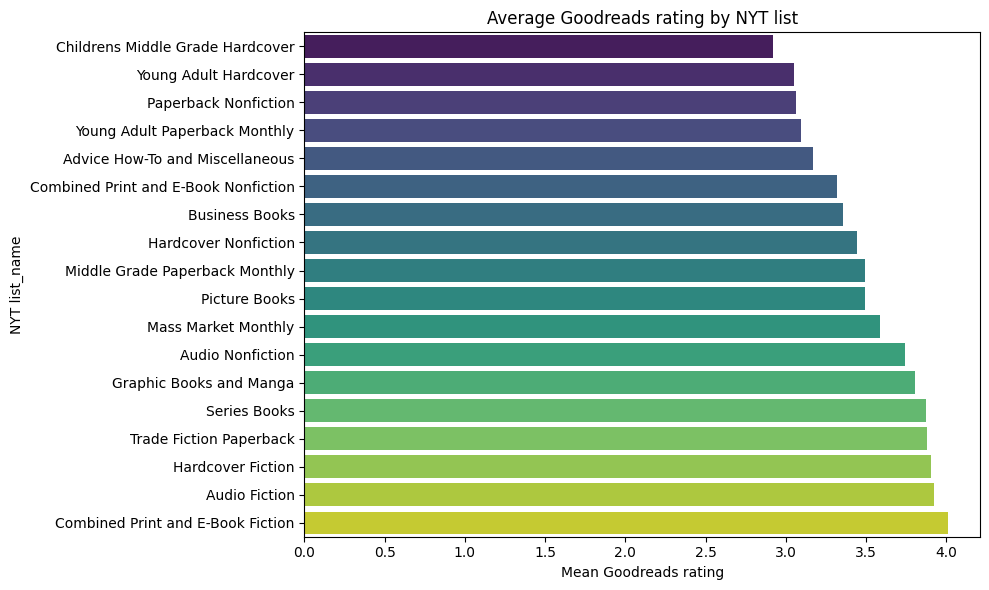

In [100]:
con = duckdb.connect(DB_FILE, read_only=True)



list_stats = con.execute("""

    SELECT

        n.list_name,

        ROUND(AVG(g.average_rating), 3) AS mean_rating,

        COUNT(*)                       AS n_books

    FROM   nyt_raw AS n

    JOIN   goodreads   AS g USING (isbn13)

    WHERE  g.average_rating IS NOT NULL

    GROUP  BY n.list_name

    ORDER  BY mean_rating DESC

""").df()



con.close()



display(list_stats)   # nice table in Jupyter / VS Code



# -- bar-chart ----------------------------------------------------

plt.figure(figsize=(10, 6))

sns.barplot(

    data=list_stats,

    y="list_name", x="mean_rating",

    palette="viridis", order=list_stats.sort_values("mean_rating").list_name

)

plt.xlabel("Mean Goodreads rating")

plt.ylabel("NYT list_name")

plt.title("Average Goodreads rating by NYT list")

plt.tight_layout()

plt.show()

GR mean by NYT list<br>
• Spread ˜ 1 ? (2.9 ? 4.0).<br>
• Adult fiction formats (“Combined Print + E-book Fiction”, “Audio Fiction”, “HC Fiction”) top the chart.<br>
• Kids/YA lists and practical NF lag.	– The gap aligns with audience leniency rather than literary merit.<br>

<br>
– When later predicting ratings for future NYT contenders, add list_name (or genre embedding) so the model doesn’t punish a Picture-Book for scoring “only” 3.3 ?.<br>
– Try to merge low-N children’s lists into a single “Juvenile” bucket to stabilise estimates.

## 2.13 Recent vs. older publications (using Hardcover or NYT dates) gauge recency bias; 

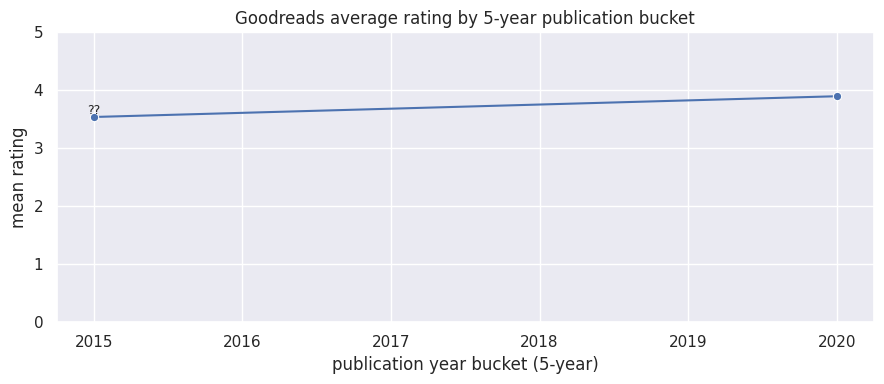

/tmp/ipykernel_35317/2382056596.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lag_buckets, x="lag_bucket", y="n_titles", palette="crest")


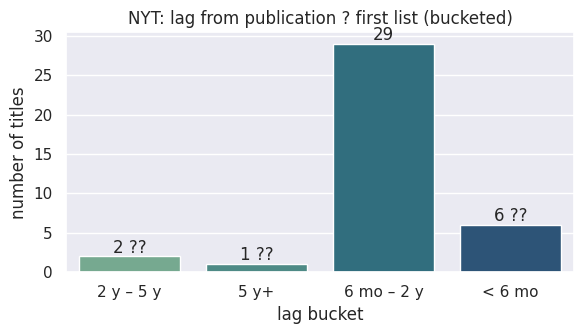

In [103]:
sns.set_theme()



######################################################################

# 0 · DB connect (read-only is fine)                                  #

######################################################################

con = duckdb.connect(DB_FILE, read_only=True)





######################################################################

# 1 · Goodreads recency bias  (fallback version – no publication_year)

######################################################################

gr_yearly = con.sql("""

    WITH dated AS (

        SELECT

            g.book_id,

            -- try the hardcover date first

            EXTRACT(year FROM p.pub_date) AS hc_year,

            -- fallback: if you later add gr.publication_date, extract it here

            NULL                          AS gr_year,   -- placeholder

            g.average_rating

        FROM   goodreads g

        LEFT   JOIN pub_dates p USING (isbn13)

        WHERE  g.average_rating IS NOT NULL

    )

    SELECT

        COALESCE(hc_year, gr_year) AS year,

        COUNT(*)                   AS n_books,

        ROUND(AVG(average_rating),3) AS mean_rating

    FROM   dated

    WHERE  year BETWEEN 1950 AND 2024   -- keep the guard-rail

    GROUP  BY year

    ORDER  BY year

""").df()




# —— five-year buckets

gr_yearly["bucket5"] = (gr_yearly["year"] // 5) * 5

gr_bucket5 = (gr_yearly

              .groupby("bucket5", as_index=False)

              .agg(n_books=("n_books","sum"),

                   mean_rating=("mean_rating","mean")))



# flag anecdotal buckets

gr_bucket5["flag"] = gr_bucket5["n_books"].lt(15)



# —— plot

plt.figure(figsize=(9,4))

sns.lineplot(data=gr_bucket5, x="bucket5", y="mean_rating", marker="o")

for _, row in gr_bucket5.iterrows():

    if row["flag"]:

        plt.text(row["bucket5"], row["mean_rating"], "??",

                 ha="center", va="bottom", fontsize=9)



plt.title("Goodreads average rating by 5-year publication bucket")

plt.ylabel("mean rating")

plt.xlabel("publication year bucket (5-year)")

plt.ylim(0,5)

plt.tight_layout()

plt.show()





######################################################################

# 2 · NYT lag buckets (publication ? first list appearance)           #

######################################################################


lag_buckets = con.sql("""

    WITH lags AS (

        SELECT

            ROUND(

                DATE_DIFF(

                    'day',

                    p.pub_date,                              -- DATE already

                    CAST(n.published_date AS DATE)           -- ? explicit cast

                )::DOUBLE / 7.0 , 1

            ) AS weeks_lag

        FROM   nyt_raw   AS n

        JOIN   pub_dates AS p USING (isbn13)

    )

    SELECT

        CASE

            WHEN weeks_lag <  26 THEN '< 6 mo'

            WHEN weeks_lag < 104 THEN '6 mo – 2 y'

            WHEN weeks_lag < 260 THEN '2 y – 5 y'

            ELSE                     '5 y+'

        END        AS lag_bucket,

        COUNT(*)   AS n_titles

    FROM   lags

    GROUP  BY lag_bucket

""").df().sort_values("lag_bucket")




# flag low-N buckets

lag_buckets["flag"] = lag_buckets["n_titles"].lt(15)



# —— bar chart

plt.figure(figsize=(6,3.5))

sns.barplot(data=lag_buckets, x="lag_bucket", y="n_titles", palette="crest")

for idx, row in lag_buckets.iterrows():

    label = f"{row['n_titles']}"

    if row["flag"]:

        label += " ??"

    plt.text(idx, row["n_titles"]+0.5, label, ha="center")

plt.title("NYT: lag from publication ? first list (bucketed)")

plt.ylabel("number of titles")

plt.xlabel("lag bucket")

plt.tight_layout()

plt.show()



con.close()



2·13a<br>
GR mean by 5-year bucket<br>
Only two buckets survive the HC-date join (2015 & 2020) ? sample too thin to call.<br>	
Park long-term recency analysis until you ingest publication years directly from Goodreads
(they are present in the HTML).	

2·13b<br>
NYT lag buckets	• 29/38 titles debut 6 mo – 2 y after pub-date ? typical “front-list”.<br>
• Only 3 back-list revivals (= 2 y).<br>	
Good: the lag table confirms NYT mostly spotlights recent releases.<br>
Use the bucketed lag as a categorical feature rather than raw weeks (will reduce noise).<br>

## 2.14  Goodreads – rating dispersion (stdev & coefficient-of-variation)

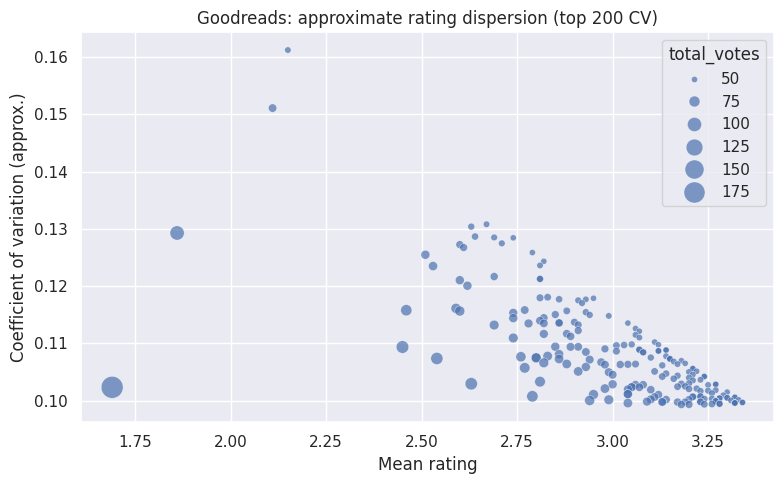

,book_id,mean,stdev,cv,total_votes
0,149036,2.15,0.346622,0.161220,51
1,1771181,2.11,0.318797,0.151089,60
2,509798,2.67,0.349260,0.130809,51
3,227615,2.63,0.342937,0.130394,53
4,2574850,1.86,0.240470,0.129285,101
5,1359702,2.64,0.339673,0.128664,54
6,3192392,2.69,0.345685,0.128507,52
7,302576,2.74,0.351920,0.128438,50
8,4286101,2.71,0.345462,0.127477,52
9,325542,2.60,0.330868,0.127257,57


In [108]:
# ---------------------------------------------------------------

# 0 · connect  (read-only is fine)

# ---------------------------------------------------------------

con = duckdb.connect(DB_FILE, read_only=True)



# ---------------------------------------------------------------

# 1 · approximate dispersion

# ---------------------------------------------------------------

dispersion = con.sql("""

    WITH approx AS (

        SELECT

            book_id,

            average_rating                    AS mean,

            ratings_count                     AS n,

            /* s ˜ v[p·(1–p)/n]·5  */

            SQRT((average_rating/5.0)*(1-average_rating/5.0)

                 / GREATEST(ratings_count,1)) * 5          AS stdev

        FROM   goodreads

        WHERE  ratings_count >= 50

          AND  average_rating IS NOT NULL

    )

    SELECT

        book_id,

        mean,

        stdev,

        stdev / NULLIF(mean,0)               AS cv,

        n                                    AS total_votes

    FROM   approx

    ORDER  BY cv DESC

    LIMIT  200

""").df()



# ---------------------------------------------------------------

# 2 · scatterplot (mean vs. CV, bubble = votes)

# ---------------------------------------------------------------

plt.figure(figsize=(8,5))

sns.scatterplot(

    data=dispersion,

    x="mean", y="cv",

    size="total_votes", sizes=(20,250), alpha=.7

)

plt.title("Goodreads: approximate rating dispersion (top 200 CV)")

plt.xlabel("Mean rating")

plt.ylabel("Coefficient of variation (approx.)")

plt.tight_layout()

plt.show()



display(dispersion.head(15))



# ---------------------------------------------------------------

# 3 · close connection LAST

# ---------------------------------------------------------------

con.close()

Observation<br>
Dispersion (CV) top 200	• CV range 0.10–0.16 under your approximate formula.<br>

• Lower means tend to have higher CV – consistent with polarised reception.<br>
– A high-CV flag is worth keeping (signals “love-it/loathe-it” titles).<br>
– For final features use log10(1/CV) or a binary “controversial” label (> 0.13).<br>
– Remember CV shrinks with vote count: consider z-score normalising by expected s under binomial.